In [1]:
import zipfile
import os
import pandas as pd

In [2]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df['mes'] = df['data_base'].dt.month #cria uma nova coluna com mês
            df['ano'] = df['data_base'].dt.year
            #Filtros:
            df = df[df['cliente'] == 'PF'] #trocar para o ano que você quer filtrar
            df['porte'] = df['porte'].str.replace(' ','')
#           filtro1 = df['porte'] == "PJ-Micro"
#           filtro2 = df['porte'] == "PJ-Pequeno"
#           df = df.loc[filtro1 | filtro2]
            df = df[['a_vencer_de_1081_ate_1800_dias','data_base', 'modalidade', 'porte', 'a_vencer_de_361_ate_1080_dias', 
  'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias']]
            #Nova coluna para endividamento de LONGO prazo
            df['longo_prazo'] = df['a_vencer_de_361_ate_1080_dias'] + df['a_vencer_de_1081_ate_1800_dias'] + df['a_vencer_de_1801_ate_5400_dias'] + df['a_vencer_acima_de_5400_dias']
            df = df.drop(columns = ['a_vencer_de_361_ate_1080_dias', 'a_vencer_de_1081_ate_1800_dias', 'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias'], axis = 1)
            df['data_base'] = df['data_base'].dt.strftime('%Y-%m')
            #Agrupamentos para análise
            df = df.groupby(['data_base','modalidade','porte'])['longo_prazo'].sum().reset_index()
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [3]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [4]:
df_total['data_base'] = pd.to_datetime(df_total['data_base'])

In [5]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8381 entries, 0 to 503
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data_base    8381 non-null   datetime64[ns]
 1   modalidade   8381 non-null   object        
 2   porte        8381 non-null   object        
 3   longo_prazo  8381 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 327.4+ KB


In [11]:
import deflatebr as dbr
nominal_values = df_total['longo_prazo']
nominal_dates = df_total['data_base']
real_date = '2023-01'

#criar uma coluna com o valor deflacionado
df_total['valor_deflacionado'] = dbr.deflate(nominal_values=nominal_values, nominal_dates=nominal_dates, real_date=real_date,
           index='ipca', progress_bar=True, on_jupyter=True)

  0%|          | 0/8381 [00:00<?, ?it/s]

/Users/brunamoura/anaconda3/lib/python3.11/site-packages/deflatebr/deflate.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['deflated'] = df[['nom_values', 'VALVALOR']].progress_apply(lambda x: ((real_indx/x[1]) * x[0])[0], axis=1)


In [12]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_total.head(3)

,data_base,modalidade,porte,longo_prazo,valor_deflacionado
0,2012-06-01,PF - Cartão de crédito,PF-Acimade20saláriosmínimos,68774813.22,128626928.73
1,2012-06-01,PF - Cartão de crédito,PF-Até1saláriomínimo,41404241.81,77436785.52
2,2012-06-01,PF - Cartão de crédito,PF-Indisponível,772.32,1444.44


In [13]:
df_total['data_base'] = pd.to_datetime(df_total['data_base']).dt.strftime('%Y-%m')

In [14]:
# Importando a série do IPCA mensal (a)
#importa a bibliotaca
import requests

#define a url a ser usada
url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json'
# fazendo a requisição à url e trazendo em formato json
inflacao_mensal = requests.get(url).json() 
#response é o nome da 'variável'. Pode ser qualquer outro nome

# visualizando os primeiros elementos da base
inflacao_mensal[500:505]

[{'data': '01/09/2021', 'valor': '1.16'},
 {'data': '01/10/2021', 'valor': '1.25'},
 {'data': '01/11/2021', 'valor': '0.95'},
 {'data': '01/12/2021', 'valor': '0.73'},
 {'data': '01/01/2022', 'valor': '0.54'}]

In [15]:
inflacao = pd.DataFrame(inflacao_mensal)

In [16]:
inflacao['data'] = pd.to_datetime(inflacao['data'], format = "%d/%m/%Y")

In [17]:
inflacao['data'] = inflacao['data'].dt.strftime('%Y-%m')

In [18]:
inflacao.head()

,data,valor
0,1980-01,6.62
1,1980-02,4.62
2,1980-03,6.04
3,1980-04,5.29
4,1980-05,5.70


In [36]:
df_total['data_base'] = pd.to_datetime(df_total['data_base']).dt.strftime('%Y-%m')

In [20]:
df_inflacao_modalidade_agrupado = df_total.groupby(['data_base', 'modalidade'])['valor_deflacionado'].sum().reset_index()

In [21]:
df_inflacao_modalidade_agrupado =  pd.merge(inflacao,
                              df_inflacao_modalidade_agrupado,
                              left_on="data",
                              right_on="data_base",
                              how = "inner")

In [38]:
df_inflacao_modalidade_agrupado['valor']=df_inflacao_modalidade_agrupado['valor'].astype(float)

In [44]:
df_inflacao_modalidade_agrupado['modalidade']=df_inflacao_modalidade_agrupado['modalidade'].str.replace('PF - ','')

In [45]:
df_inflacao_modalidade_agrupado.to_csv("pf_modalidade_endividamentolp_inflacao.csv")

In [24]:
import plotly.graph_objects as go

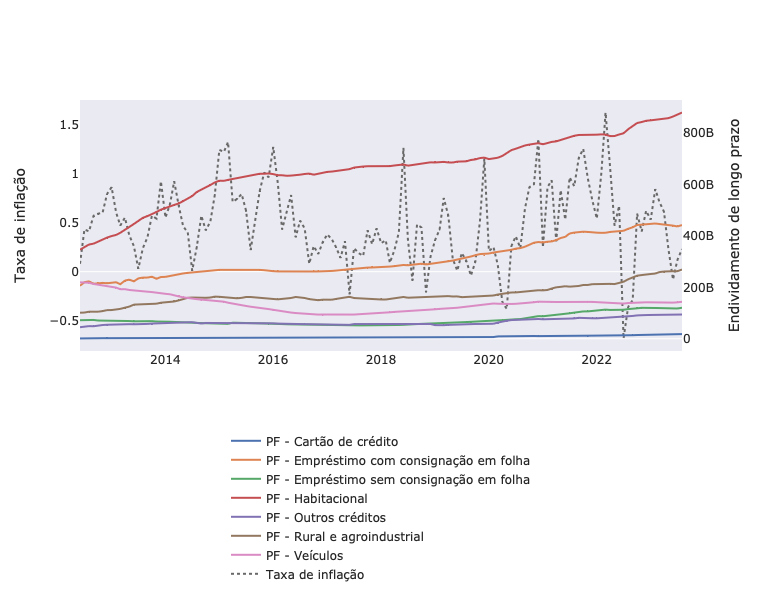

In [42]:
fig = go.Figure()

for modalidade in df_inflacao_modalidade_agrupado['modalidade'].unique():
    subset = df_inflacao_modalidade_agrupado[df_inflacao_modalidade_agrupado['modalidade'] == modalidade]
    fig.add_trace(go.Scatter(x=subset['data'],
                             y=subset['valor_deflacionado'],
                             mode='lines',
                             name=f'{modalidade}',
                             yaxis='y2',
                            line = dict(width=2)))
    
# Adicionando a coluna 'valor' ao segundo eixo y
fig.add_trace(go.Scatter(x=df_inflacao_modalidade_agrupado['data'],
                         y=df_inflacao_modalidade_agrupado['valor'], 
                         mode='lines',
                         name='Taxa de inflação',
                        opacity=1,
                        line=dict(color='dimgray', width=2, dash='dot')))

fig.update_layout(
    yaxis2=dict(
        overlaying='y',
        side='right',
        showgrid=False,
        title="Endividamento de longo prazo"
    ),
    template="seaborn",
    legend=dict(
        x=0.5,
        y=-0.3,
        orientation='h',
        xanchor='center'
    ),
    xaxis=dict(showgrid=False),
    yaxis=dict(
        showgrid=False,
        title="Taxa de inflação"
    ),
    height=600,
    width=700,
)

fig.show()